In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import zarr
import json
import pandas as pd
import datetime
import torch
from torch.utils.data import DataLoader
import cartopy.crs as ccrs
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import FFMpegWriter

from utils import *

In [ ]:
zarr_file ='evaluation_metrics.zarr'

var_names = ['z500', 't850', 't2m', 'u10', 'v10', 'ws10']

#linestyles = ['dotted', 'dashed', ':','dashdot', 'solid']
linestyles = ['solid', 'solid', 'solid','solid', 'solid']

colors = ['#008000','#0000FF','#EF228E','#74362F', '#FFA500' ,]  # Extend as needed
eval_names = ['model1', 'model2']
legend_names =['Model 1', 'Model 2']
plot_name = 'test_plot'

# Open the Zarr file
zarr_root = zarr.open_group(zarr_file, mode='r')

# Initialize a dictionary to store all metrics for each eval_name
metrics_dict = {}

# Loop through each eval_name and load the corresponding metrics
for eval_nm in eval_names:
    if eval_nm in zarr_root:
        metrics_dict[eval_nm] = {
            'RMSE': zarr_root[eval_nm]['RMSE'][:],
            'spread': zarr_root[eval_nm]['spread'][:],
            'SSR': zarr_root[eval_nm]['SSR'][:],
            'CRPS': zarr_root[eval_nm]['CRPS'][:],
            'times': zarr_root[eval_nm]['times'][:],
            'dx_same': zarr_root[eval_nm]['dx_same'],
            'dx_different': zarr_root[eval_nm]['dx_different'],
            'dx_truth': zarr_root[eval_nm]['dx_truth'],
        }
    else:
        print(f"Warning: {eval_nm} not found in Zarr file.")

# Now metrics_dict contains all the metrics for each eval_name
print(metrics_dict)

{'iterative-24h-long': {'RMSE': array([[117.01148  ,   1.0908026,   1.0820174,   1.5009695,   1.593776 ,
          1.2345963],
       [209.85597  ,   1.4402539,   1.3545213,   2.0857577,   2.072394 ,
          1.6408843],
       [327.6052   ,   1.7952038,   1.50983  ,   2.5911136,   2.5474443,
          1.8998468],
       [433.763    ,   2.2349398,   1.7823681,   3.1014748,   2.917455 ,
          2.2165158],
       [499.2689   ,   2.5708404,   2.0761242,   3.4825838,   3.4689841,
          2.4185011],
       [621.22986  ,   2.7063336,   2.3794365,   3.7934663,   3.8614233,
          2.5436609],
       [687.8222   ,   2.9948986,   2.4515414,   3.5966623,   3.867726 ,
          2.477751 ],
       [656.0101   ,   3.1858761,   2.4229915,   3.4377086,   3.7295349,
          2.4565303],
       [682.4093   ,   3.48844  ,   2.5835283,   3.4085388,   3.643042 ,
          2.5433905],
       [723.91705  ,   3.4938073,   2.8920574,   3.3848598,   3.641804 ,
          2.406056 ],
       [778.36395 

## Plot Metrics

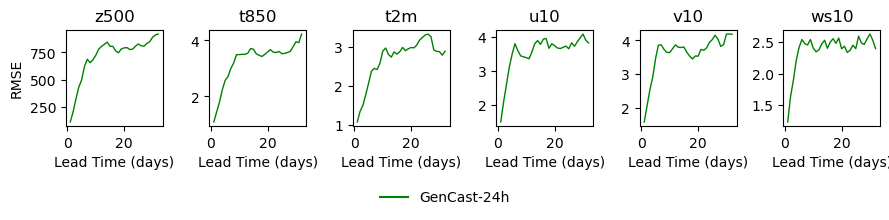

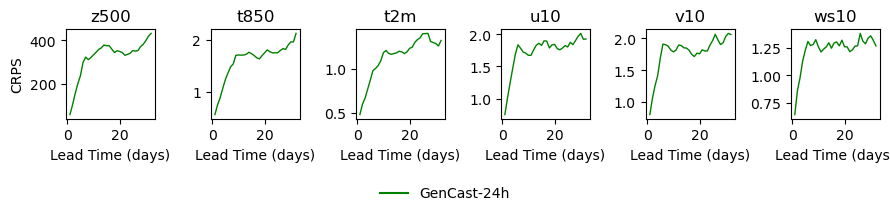

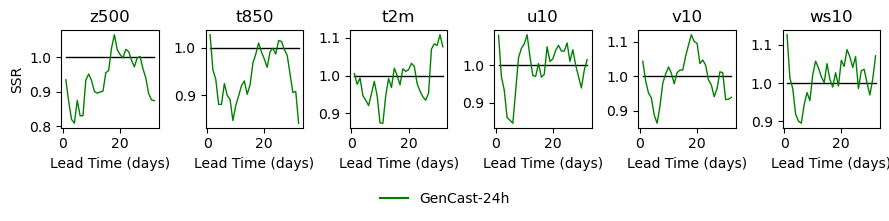

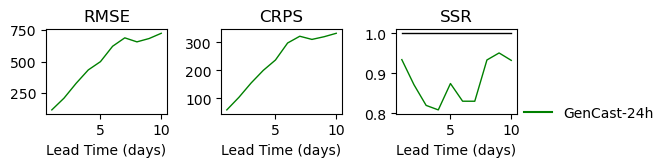

In [ ]:
def plot_metric(metric_type, var_ch=0, combined=False, x_max=10.5, scale=1.0, save=False):
    assert metric_type in ['RMSE', 'CRPS', 'SSR'], f"Unsupported metric_type: {metric_type}"

    def _get_days(times, x_max):
        if x_max > 1:
            return [t / 24 for t in times if t / 24 <= x_max], 'days'
        else:
            return [t for t in times if t <= x_max * 24], 'hours'

    def _plot_single(ax, var_ch, metric_type, ylabel=False, combined=False):
        for idx, eval_name in enumerate(eval_names):
            if legend_names[idx] == 'null':
                continue
            metric = metrics_dict[eval_name][metric_type]  # skill/crps/ssr
            times = metrics_dict[eval_name]['times'][:]
            days, time_unit = _get_days(times, x_max)
            values = metric[:len(days), var_ch]

            ax.plot(days, values, label=legend_names[idx],
                    color=colors[idx], linestyle=linestyles[idx],
                    linewidth=1, zorder=10 - idx, markersize=0)

        if metric_type == 'SSR':
            ax.plot(days, np.ones_like(days), linewidth=1, color='k')

        ax.set_xlabel(f'Lead Time ({time_unit})')
        if time_unit == 'days':
            ax.set_xticks(np.arange(1, x_max, 2))
            ax.set_xticks(np.arange(0, x_max, 1), minor=True)
            ax.set_xlim(left=-x_max / 20, right=x_max)
        else:
            ax.set_xticks(np.arange(6, x_max * 24, 6))
            ax.set_xticks(np.arange(0, x_max * 24, 3), minor=True)
            ax.set_xlim(left=-x_max / 20, right=x_max * 24)

        ax.set_box_aspect(scale)
        if combined:
            ax.set_title(metric_type)
        else:
            ax.set_title(var_names[var_ch])
            if var_ch == 0 or ylabel:
                ax.set_ylabel(metric_type)

    # Setup plotting
    if combined:
        fig, axs = plt.subplots(1, 3, figsize=(1.8 * 3, 1.6))
        for i, m in enumerate(['RMSE', 'CRPS', 'SSR']):
            _plot_single(axs[i], var_ch, m, combined=True)
        handles, labels = axs[0].get_legend_handles_labels()
        handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.1, 0.19), ncol=1, frameon=False)
    else:
        fig, axs = plt.subplots(1, len(var_names), figsize=(1.5 * len(var_names), 1.7))
        for i in range(len(var_names)):
            _plot_single(axs[i], i, metric_type)
        handles, labels = axs[0].get_legend_handles_labels()
        handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(eval_names), frameon=False)

    plt.tight_layout()

    if save:
        if combined:
            fig.savefig(f'{plot_name}_{var_names[var_ch]}_metrics.png', dpi=300, bbox_inches='tight')
        else:
            fig.savefig(f'{plot_name}_{metric_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot RMSE for all variables
plot_metric('RMSE')

# Plot CRPS for all variables
plot_metric('CRPS')

# Plot SSR for all variables
plot_metric('SSR')

# Combined comparison for variable 5
plot_metric('RMSE', var_ch=0, combined=True, scale=0.7)


In [ ]:
def plot_temp_diff(var_ch=None, combined=False, scale=1.0, save=False):
    def _plot_single(ax, var_ch, ylabel=False, combined=False):
        for idx, eval_name in enumerate(eval_names):
            if 'null' in legend_names[idx]:
                continue
            dx_truth = np.mean(metrics_dict[eval_name]['dx_truth'], axis=0)
            dx_same = metrics_dict[eval_name]['dx_same'] / dx_truth
            dx_different = metrics_dict[eval_name]['dx_different'] / dx_truth
            forecasting_times = metrics_dict[eval_name]['times'][1:]
            days = forecasting_times[:23]

            ax.plot(days, dx_same[:23, var_ch], label='Fixed Noise',
                    color=colors[idx], linestyle=linestyles[idx],
                    linewidth=1, zorder=10 - idx)
            ax.plot(days, dx_different[:23, var_ch], label='Uncorrelated Noise',
                    color=colors[idx+1], linestyle=linestyles[idx],
                    linewidth=1, zorder=10 - idx)

        ax.set_xlabel('Lead Time (hours)')
        ax.set_xticks(np.arange(0, 25, 12))
        ax.set_xlim(left=-0.5, right=26)
        ax.set_box_aspect(scale)

        if combined:
            ax.set_title('$\Delta$X')
        else:
            ax.set_title(var_names[var_ch])
            if var_ch == 0 or ylabel:
                ax.set_ylabel('$\Delta$X')
            ax.set_ylim(bottom=-0.1)

    if combined:
        fig, ax = plt.subplots(1, 1, figsize=(4.8, 1.6))
        _plot_single(ax, var_ch, combined=True)
        handles, labels = ax.get_legend_handles_labels()
        handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(1.15, 0.24), ncol=1, frameon=False)
    else:
        fig, axs = plt.subplots(1, len(var_names), figsize=(1.5 * len(var_names), 1.7))
        for i in range(len(var_names)):
            _plot_single(axs[i], i)
        handles, labels = axs[0].get_legend_handles_labels()
        handles = [plt.Line2D([], [], color=h.get_color(), linewidth=1.5) for h in handles]
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(eval_names), frameon=False)

    plt.tight_layout()

    if save:
        if combined:
            fig.savefig(f'{plot_name}_{var_names[var_ch]}_noise.png', dpi=300, bbox_inches='tight')
        else:
            fig.savefig(f'{plot_name}_noise.png', dpi=300, bbox_inches='tight')
    plt.show()

# Panel plot for all variables
plot_temp_diff()

# Combined noise comparison for a single variable (e.g., var_ch = 5)
plot_temp_diff(var_ch=5, combined=True)


## Plot forecast

In [ ]:
data_directory = '../data'
result_directory = './results'
model_directory = './models'

model = 'iterative-24h'
predictions = zarr.open(f'{result_directory}/{model}/{model}.zarr', mode='r')

variable_names = ['z500', 't850', 't2m', 'u10', 'v10']
num_variables, num_static_fields = 5, 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_horizon = 240 # Maximum time horizon for the model. Used for scaling time embedding and making sure we don't go outside dataset


In [29]:
config_path = f'{result_directory}/{model}/config.json'

def load_config(json_file):
    with open(json_file, 'r') as file:
        config = json.load(file)
    return config

config_path =config_path
config = load_config(config_path)

# Load config
name        =   config['name']
spacing     =   config['spacing']
t_direct =      config['t_direct']
t_max =         config['t_max']
batch_size =    config['batch_size']
t_min =         t_direct
t_iter =        config['t_iter']
n_ens =         config['n_ens']
model_path =    config['model']

# Load normalization factors
with open(f'{data_directory}/norm_factors.json', 'r') as f:
    statistics = json.load(f)
mean_data = torch.tensor([stats["mean"] for (key, stats) in statistics.items() if key in variable_names])
std_data = torch.tensor([stats["std"] for (key, stats) in statistics.items() if key in variable_names])
norm_factors = np.stack([mean_data, std_data], axis=0)
mean_data = mean_data
std_data = std_data
def renormalize(x, mean_ar=mean_data, std_ar=std_data):
    x = x * std_ar[None, :, None, None] + mean_ar[None, :, None, None]
    return x

# Get the number of samples, training and validation samples
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')
n_samples, n_train, n_val = len(ti), sum(ti.year <= 2015), sum((ti.year >= 2016) & (ti.year <= 2017))

# Load config of trained model
train_config_path = f'{model_directory}/{model_path}/config.json'
config = load_config(train_config_path)
conditioning_times = config['conditioning_times']

lat, lon = np.load(f'{data_directory}/latlon_1979-2018_5.625deg.npz').values()

kwargs = {
            'dataset_path':     f'{data_directory}/z500_t850_t2m_u10_v10_1979-2018_5.625deg.npy',
            'sample_counts':    (n_samples, n_train, n_val),
            'dimensions':       (num_variables, 32, 64),
            'max_horizon':      max_horizon, # For scaling the time embedding
            'norm_factors':     norm_factors,
            'device':           device,
            'spacing':          spacing,
            'dtype':            'float32',
            'conditioning_times':    conditioning_times,
            'lead_time_range':  [t_min, t_max, t_direct],
            'static_data_path': f'{data_directory}/orog_lsm_1979-2018_5.625deg.npy',
            'random_lead_time': 0,
            }

forecasting_times = t_min + t_direct * np.arange(0, 1 + (t_max-t_min)//t_direct)
dataset = ERA5Dataset(lead_time=forecasting_times, dataset_mode='test', **kwargs)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [30]:
# Get the first batch
with torch.no_grad():
    i=0
    for previous, current, time_labels in (loader):
        n_times = time_labels.shape[1]
        n_samples, _, dx, dy = current.shape

        truth = renormalize(current.view(n_samples, n_times, num_variables, dx, dy))
       
        forecast = predictions[i:i + truth.shape[0]]
        forecast = torch.tensor(forecast, device=device)
        i = i + truth.shape[0]
        
        # Add windspeed
        w_truth = (truth[:,:,3]**2 + truth[:,:,4]**2).sqrt().unsqueeze(2)
        truth = torch.cat((truth, w_truth), dim=2)
        w_forecast = (forecast[:,:,:,3]**2 + forecast[:,:,:,4]**2).sqrt().unsqueeze(3)
        forecast = torch.cat((forecast, w_forecast), dim=3)
        break   

In [ ]:
def plot_forecast(
    truth,
    forecast,
    forecasting_times,
    var_ch=0,
    save=False,
    animate=False,
    cmap=plt.cm.get_cmap('RdBu_r'),
):
    """
    Plots ensemble forecast comparison with truth and uncertainty.
    
    Parameters:
        truth: Tensor [batch, time, variable, ...]
        forecast: Tensor [batch, ensemble, time, variable, ...]
        forecasting_times: Tensor of forecast times
        lon, lat: 2D arrays for pcolormesh
        var_ch: Variable channel index to plot
        sample_idx: Which batch sample to visualize
        var_names: List of variable names
        units: List of units per variable
        animate: If True, returns an animation. Else, static image.
        save_path: If provided, saves output to this path
        cmap: Matplotlib colormap
    """

    units = [r'm$^2$s$^{−2}$', 'K', 'K', r'ms$^{-1}$', r'ms$^{-1}$', r'ms$^{-1}$']

    rc('animation', html='html5')

    dt = len(forecasting_times)
    dx, dy = forecast.shape[-2], forecast.shape[-1]
    
    # Extract and reshape data
    truth_plot = truth[0, :, var_ch].cpu().numpy().reshape((-1, dx, dy))
    forecast_plot = forecast[0, :, :, var_ch].cpu().numpy().reshape((forecast.shape[1], dt, dx, dy))
    ens_mean = forecast_plot.mean(axis=0)
    ens_std = forecast_plot.std(axis=0)

    # Set up figure
    fig, axes = plt.subplots(2, 3, figsize=(6, 2.5), subplot_kw={'projection': ccrs.Robinson()})
    txt_title = fig.suptitle('t=0', va='top')
    images = []

    # Plot initialization
    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            data = truth_plot[0]
        elif i == 1:
            data = ens_mean[0]
        elif i == 2:
            data = ens_std[0]
        else:
            data = forecast_plot[i - 3, 0]
            ax.set_title(f'Sample #{i - 2}')
        
        vmin = truth_plot.min() if i != 2 else 0
        vmax = truth_plot.max() if i != 2 else ens_std.max()

        im = ax.pcolormesh(lon, lat, data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        images.append(im)

    # Titles
    axes[0, 0].set_title('Truth')
    axes[0, 1].set_title('Ensemble mean')
    axes[0, 2].set_title('Ensemble std')

    # Colorbars
    fig.colorbar(images[2], ax=axes[0, 2], orientation='vertical', fraction=0.025, pad=0.04).set_label('Std Dev.')
    fig.colorbar(images[-1], ax=axes[1, 2], orientation='vertical', fraction=0.025, pad=0.04).set_label(units[var_ch] if units else '')

    # Frame updater
    def drawframe(n):
        images[0].set_array(truth_plot[n].ravel())
        images[1].set_array(ens_mean[n].ravel())
        images[2].set_array(ens_std[n].ravel())
        for i in range(3, len(images)):
            images[i].set_array(forecast_plot[i - 3, n].ravel())
        txt_title.set_text(f't = {forecasting_times[n].item()} h')
        return images

    fig.tight_layout()

    if animate:
        anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)
        if save:
            writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
            anim.save(f'{plot_name}_{var_names[var_ch]}_animation.mp4', writer=writer, dpi=300)
        return HTML(anim.to_html5_video())
    else:
        drawframe(len(forecasting_times) - 1)
        if save:
            fig.savefig(f'{plot_name}_{var_names[var_ch]}_image.png', dpi=300, bbox_inches='tight')
        return fig


/var/folders/_9/17shwps5601dr6hg80bpbnjc0000gp/T/ipykernel_14537/3451122218.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('RdBu_r'),


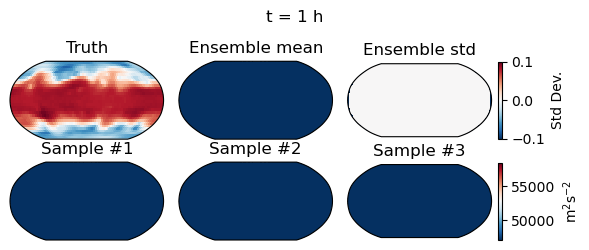

In [ ]:
plot_forecast(
    truth, forecast, forecasting_times,
    var_ch=2,
    animate=True,
    save = True,
)

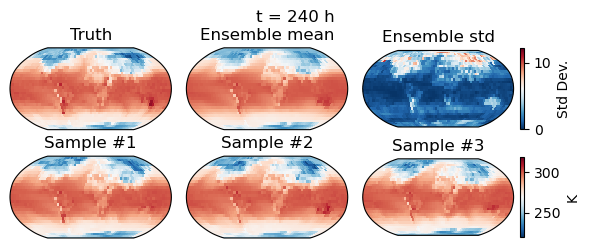

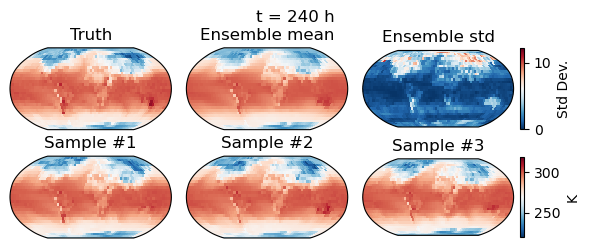

In [ ]:
plot_forecast(
    truth, forecast, forecasting_times, 
    var_ch=2,
    animate=False,
    save=True
)